In [1]:
## dataset
#import tensorflow.keras as keras
## for Model definition/training
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Flatten, Dense, concatenate,  Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K


from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint

## required for semi-hard triplet loss:
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.framework import dtypes
import tensorflow as tf

## for visualizing 
import matplotlib.pyplot as plt, numpy as np
from sklearn.decomposition import PCA
import pandas as pd
import seaborn as sns

import random
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from numpy.random import RandomState
from itertools import chain
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import scale
from sklearn.linear_model import LogisticRegression
from copy import copy

from collections import Counter
from mord import LogisticAT
import math
from matplotlib.offsetbox import AnchoredText
from os import listdir
import sys
sys.path.append('functions.py')
%run functions.py
%run ml_functions.py

In [2]:
def expandTimepoints(data, mapping, should_encode = False):
    expanded_time = pd.DataFrame()
    for host_name in np.unique(mapping.host_name):
        df_small = data.loc[mapping.host_name == host_name, :]
        if should_encode:
            df_small = encode(df_small, autoencoder_16s)
        expanded_timepoints = df_small.to_numpy().reshape((1, 3*df_small.shape[1]))[0]
        expanded_time = expanded_time.append(pd.Series(expanded_timepoints), ignore_index = True)
    expanded_time.index = np.unique(mapping.host_name)
    return(expanded_time)

x_16s, map_16s = get16sData(filt = False)
exp_16s = expandTimepoints(x_16s, map_16s)

(453, 5265)


In [12]:
x_mtg,  map_mtg = getMtgData(filt = False)
print(x_mtg.shape)
x_mtg = x_mtg + 1
x_mtt, map_mtt = getMttData(filt = False)
x_mtt = x_mtt + 1
x_mbx, map_mbx = getMetabolData()
x_mbx = x_mbx + 1
x_mbx_filt = filterForProkaryotes(x_mbx)
x_mbx_filt = x_mbx_filt + 1

(193, 6189)
(177, 56)


In [184]:
keep = map_16s.timepoint == "Timepoint 1"
map_16s_1 = map_16s.loc[keep.values, :]
x_16s_1 = x_16s.loc[keep.values, :]

keep = map_16s.timepoint == "Timepoint 2"
map_16s_2 = map_16s.loc[keep.values, :]
x_16s_2 = x_16s.loc[keep.values, :]

keep = map_16s.timepoint == "Timepoint 3"
map_16s_3 = map_16s.loc[keep.values, :]
x_16s_3 = x_16s.loc[keep.values, :]

In [185]:
samples_keep = combineOmics(x_16s, x_mtg, x_mtt, x_mbx)
x_16s = x_16s.loc[samples_keep, :]
x_mtg = x_mtg.loc[samples_keep, :]
x_mtt = x_mtt.loc[samples_keep, :]
x_mbx = x_mbx.loc[samples_keep, :]
x_mbx_filt = x_mbx_filt.loc[samples_keep, :]
map_16s = map_16s.loc[samples_keep, :]
map_mtg = map_mtg.loc[samples_keep, :]
map_mtt = map_mtt.loc[samples_keep, :]
map_mbx = map_mbx.loc[samples_keep, :]

In [186]:
#x_16s = x_16s.groupby(map_16s.host_name).mean()
#x_mtg = x_mtg.groupby(map_mtg.host_name).mean()
#x_mtt = x_mtt.groupby(map_mtt.host_name).mean()
#x_mbx = x_mbx.groupby(map_mbx.host_name).mean()
#x_mbx_filt = x_mbx_filt.groupby(map_mbx.host_name).mean()
#samples_keep = combineOmics(x_16s, x_mtg, x_mtt, x_mbx)


In [187]:
all_omics = pd.concat([x_16s, x_mtg, x_mtt, x_mbx], axis = 1)

#map_16s = formatMapping(map_16s, samples_keep)
#map_mtg = formatMapping(map_mtg, samples_keep)
#map_mtt = formatMapping(map_mtt, samples_keep)
#map_mbx = formatMapping(map_mbx, samples_keep)


In [188]:
autoencoder_16s = "weights/autoencoder/s/euclidean/500dim/ep9800_train0.049_val0.075.hdf5"
autoencoder_mtg = "weights/autoencoder/mtg/braycurtis/100dim/ep4800_train0.001_val0.000.hdf5"
autoencoder_mtt = "weights/autoencoder/mtt/braycurtis/25dim/ep3900_train0.001_val0.000.hdf5"
autoencoder_mbx = "weights/autoencoder/metabol/braycurtis/200dim/ep100_train0.007_val0.103.hdf5"
#autoencoder_mbx_filt = "weights/autoencoder/metabol/"

encoded_16s = encode(x_16s, autoencoder_16s)
encoded_mtg = encode(x_mtg, autoencoder_mtg)
encoded_mtt = encode(x_mtt, autoencoder_mtt)
encoded_mbx = encode(x_mbx, autoencoder_mbx)
#encoded_mbx_filt = encode(x_mbx_filt, autoencoder_mbx_filt)

all_omics_encoded = pd.concat([encoded_16s, encoded_mtg, encoded_mtt, encoded_mbx], axis = 1)

In [189]:
#all values should be 1
train_bool, test_bool = splitDatasets(x_16s, map_16s, return_bool= True, state = 1)
def checkMatch(data1, data2):
    print(np.sum([i == j for i,j in zip(data1.index.values, data2.index.values)]) / data1.shape[0])
    
checkMatch(x_16s, map_16s)
checkMatch(x_mtg, map_mtg)
checkMatch(x_mtt, map_mtt)
checkMatch(encoded_16s, map_16s)
checkMatch(encoded_mtg, map_mtg)
checkMatch(encoded_mtt, map_mtt)

1.0
1.0
1.0
1.0
1.0
1.0


In [190]:
def dropLowStd(data):
    return(data.loc[:, np.std(data, axis = 0) > 0])

def normalize(data):
    return((data - np.mean(data, axis = 0)) / (np.var(data, axis = 0)))

def logTransform(data):
    return(np.log(data + 1))

In [191]:
%run ml_functions.py
%run functions.py
data_storage = Storage([x_16s, x_mtg, x_mtt, x_mbx, all_omics])
encoded_storage = Storage([encoded_16s, encoded_mtg, encoded_mtt, encoded_mbx, all_omics_encoded])
mapping_storage = Storage([map_16s, map_mtg, map_mtt, map_mtt, map_mtt])
data_storage.applyFunction(dropLowStd)
encoded_storage.applyFunction(dropLowStd)
data_storage.applyFunction(scale)
encoded_storage.applyFunction(scale)
train_bool, test_bool = splitDatasets(x_16s, map_16s, return_bool= True, state = 1)


c:\users\ctata\miniconda3\envs\tf\lib\site-packages\sklearn\preprocessing\_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
c:\users\ctata\miniconda3\envs\tf\lib\site-packages\sklearn\preprocessing\_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
c:\users\ctata\miniconda3\envs\tf\lib\site-packages\sklearn\preprocessing\_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
c:\users\ctata\miniconda3\envs\tf\lib\site-packages\sklearn\preprocess

In [196]:
tmp = pd.DataFrame()

In [197]:
#prep for phenotype prediction
for i in np.arange(len(mapping_storage.getList())):
    mapping_storage.getList()[i].phenotype = [True if i == 'A' else False for i in mapping_storage.getList()[i].phenotype]

('16S', 'MTG', 'MTT', 'MBX', 'ALL')
RAW 16S
RAW MTG
RAW MTT
RAW MBX
RAW ALL
('16S', 'MTG', 'MTT', 'MBX', 'ALL')
RAW 16S
RAW MTG
RAW MTT
RAW MBX
RAW ALL
('16S', 'MTG', 'MTT', 'MBX', 'ALL')
RAW 16S
RAW MTG
RAW MTT
RAW MBX
RAW ALL
('16S', 'MTG', 'MTT', 'MBX', 'ALL')
RAW 16S
RAW MTG
RAW MTT
RAW MBX
RAW ALL


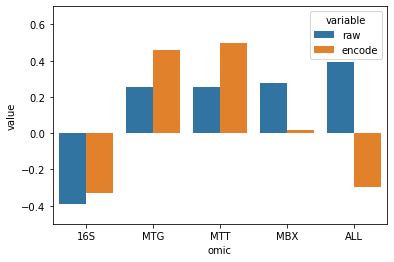

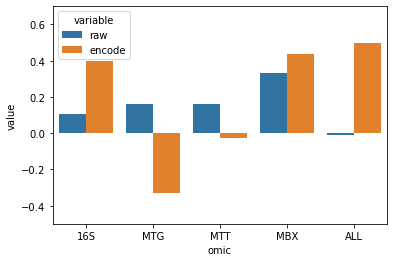

In [198]:
#criteria_list_transform = ['vegetable', 'dairy', 'olive_oil', 'seafood', 'meat', 'sweetened_drink', 'sugary_food', 
#                           'probiotic', "fruit_freq", "dairy_freq", "fat_oil_freq", "vitamin_B", "vitamin_D",
#                          "meats_and_seafood"]

criteria_list_transform = ['vegetable']
res_raw, res_encode = runCompareOmicsPipeline(data_storage, encoded_storage, mapping_storage, train_bool, test_bool,
                                              "fruit", 'rf', transformOrdinal_fruit)
tmp['fruit'] = res_raw +  res_encode
tmp.index = ['raw_16S', 'raw_MTG', 'raw_MTT', 'raw_MBX', 'raw_ALL',
                    'autoencode_16S', 'autoencode_MTG', 'autoencode_MTT', 'autoencode_MBX', 'autoencode_ALL']
for criteria in criteria_list_transform:
    res_raw, res_encode = runCompareOmicsPipeline(data_storage, encoded_storage, mapping_storage, train_bool, test_bool,
                                              criteria, 'rf', transformOrdinal_fruit)
    tmp[criteria] = res_raw +  res_encode

In [199]:
tmp.to_csv("performance_autoencoding.csv")

multivitamin
('16S', 'MTG', 'MTT', 'MBX', 'ALL')
RAW 16S
RAW MTG
RAW MTT
RAW MBX
RAW ALL
('16S', 'MTG', 'MTT', 'MBX', 'ALL')
RAW 16S
RAW MTG
RAW MTT
RAW MBX
RAW ALL
phenotype
('16S', 'MTG', 'MTT', 'MBX', 'ALL')
RAW 16S


c:\users\ctata\miniconda3\envs\tf\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ctata\miniconda3\envs\tf\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ctata\miniconda3\envs\tf\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ctata\miniconda3\envs\tf\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ctata\miniconda3\envs\tf\lib\site-packages\scipy\stats\stats.py:3508: PearsonRC

RAW MTG


c:\users\ctata\miniconda3\envs\tf\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ctata\miniconda3\envs\tf\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ctata\miniconda3\envs\tf\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ctata\miniconda3\envs\tf\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ctata\miniconda3\envs\tf\lib\site-packages\scipy\stats\stats.py:3508: PearsonRC

RAW MTT


c:\users\ctata\miniconda3\envs\tf\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ctata\miniconda3\envs\tf\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ctata\miniconda3\envs\tf\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ctata\miniconda3\envs\tf\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ctata\miniconda3\envs\tf\lib\site-packages\scipy\stats\stats.py:3508: PearsonRC

RAW MBX


c:\users\ctata\miniconda3\envs\tf\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ctata\miniconda3\envs\tf\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ctata\miniconda3\envs\tf\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ctata\miniconda3\envs\tf\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ctata\miniconda3\envs\tf\lib\site-packages\scipy\stats\stats.py:3508: PearsonRC

RAW ALL


c:\users\ctata\miniconda3\envs\tf\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ctata\miniconda3\envs\tf\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ctata\miniconda3\envs\tf\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ctata\miniconda3\envs\tf\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ctata\miniconda3\envs\tf\lib\site-packages\scipy\stats\stats.py:3508: PearsonRC

('16S', 'MTG', 'MTT', 'MBX', 'ALL')
RAW 16S


c:\users\ctata\miniconda3\envs\tf\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ctata\miniconda3\envs\tf\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ctata\miniconda3\envs\tf\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ctata\miniconda3\envs\tf\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ctata\miniconda3\envs\tf\lib\site-packages\scipy\stats\stats.py:3508: PearsonRC

RAW MTG


c:\users\ctata\miniconda3\envs\tf\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ctata\miniconda3\envs\tf\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ctata\miniconda3\envs\tf\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ctata\miniconda3\envs\tf\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ctata\miniconda3\envs\tf\lib\site-packages\scipy\stats\stats.py:3508: PearsonRC

RAW MTT


c:\users\ctata\miniconda3\envs\tf\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ctata\miniconda3\envs\tf\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ctata\miniconda3\envs\tf\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ctata\miniconda3\envs\tf\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ctata\miniconda3\envs\tf\lib\site-packages\scipy\stats\stats.py:3508: PearsonRC

RAW MBX


c:\users\ctata\miniconda3\envs\tf\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ctata\miniconda3\envs\tf\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ctata\miniconda3\envs\tf\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ctata\miniconda3\envs\tf\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ctata\miniconda3\envs\tf\lib\site-packages\scipy\stats\stats.py:3508: PearsonRC

RAW ALL


c:\users\ctata\miniconda3\envs\tf\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ctata\miniconda3\envs\tf\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ctata\miniconda3\envs\tf\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ctata\miniconda3\envs\tf\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ctata\miniconda3\envs\tf\lib\site-packages\scipy\stats\stats.py:3508: PearsonRC

dietary_supplement
('16S', 'MTG', 'MTT', 'MBX', 'ALL')
RAW 16S
RAW MTG
RAW MTT
RAW MBX
RAW ALL
('16S', 'MTG', 'MTT', 'MBX', 'ALL')
RAW 16S
RAW MTG
RAW MTT
RAW MBX
RAW ALL
nonceliac_sensitivity
('16S', 'MTG', 'MTT', 'MBX', 'ALL')
RAW 16S
RAW MTG
RAW MTT
RAW MBX
RAW ALL
('16S', 'MTG', 'MTT', 'MBX', 'ALL')
RAW 16S
RAW MTG
RAW MTT
RAW MBX
RAW ALL


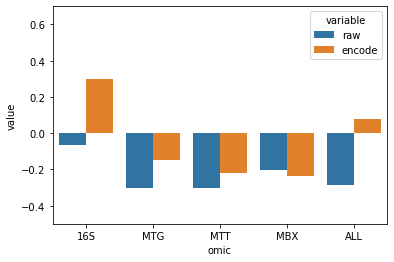

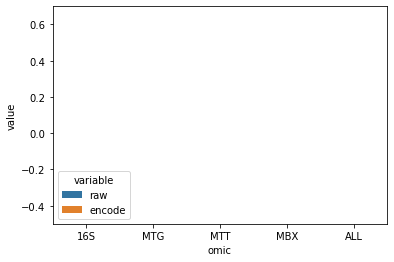

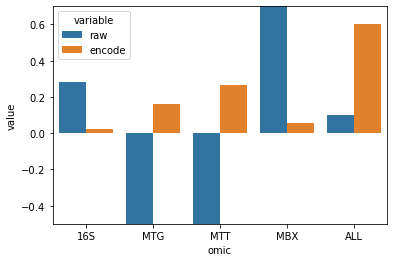

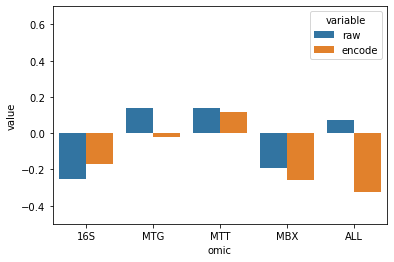

In [200]:
criteria_list_notransform = ['multivitamin', 'phenotype', "dietary_supplement", "nonceliac_sensitivity"]
for criteria in criteria_list_notransform:
    print(criteria)
    res_raw, res_encode = runCompareOmicsPipeline(data_storage, encoded_storage, mapping_storage, train_bool, test_bool,
                                              criteria, 'rf', transform = None)
    tmp[criteria] = res_raw +  res_encode

In [201]:
tmp

,fruit,vegetable,multivitamin,phenotype,dietary_supplement,nonceliac_sensitivity
raw_16S,-0.392685,0.106511,-0.063281,NaN,0.280884,-0.251342
raw_MTG,0.257351,0.159633,-0.301527,NaN,-0.824172,0.139107
raw_MTT,0.257351,0.159633,-0.301527,NaN,-0.824172,0.139107
raw_MBX,0.276176,0.332535,-0.202571,NaN,0.786667,-0.194529
raw_ALL,0.390866,-0.010993,-0.283605,NaN,0.098233,0.072136
autoencode_16S,-0.331086,0.398788,0.301371,NaN,0.020665,-0.171652
autoencode_MTG,0.457401,-0.327698,-0.145808,NaN,0.161726,-0.022948
autoencode_MTT,0.497518,-0.024690,-0.220589,NaN,0.268758,0.118018
autoencode_MBX,0.017616,0.435837,-0.234263,NaN,0.057398,-0.257894
autoencode_ALL,-0.297365,0.500085,0.080801,NaN,0.601747,-0.324197


In [202]:
tmp.to_csv("performance_autoencoding.csv")

# Sqrt and centered